#Reward modelling

## Data Preparation and Exploratory analysis

In [ ]:
%pip install -q numpy pandas datasets transformers tqdm safetensors scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
DATASET_DIR_PATH = "/gdrive/MyDrive/ФТиАД/ВКР/dataset"
FEEDBACK_FILE_NAME = "feedback.csv"

RANDOM_STATE = 42

MULTIMODAL_DATASET_SAVEPATH = "/content/multimodal_feedback"
HF_DATASET_REPO = "il-pugin/hse-prog-task-transformer-feedback"

In [ ]:
import os
import pandas as pd


feedback_filepath = os.path.join(DATASET_DIR_PATH, FEEDBACK_FILE_NAME)
raw_feedback_df = pd.read_csv(feedback_filepath)
raw_feedback_df.head()

,base_model_name,model_version,user_group_cd,messages,prompt_id,prompt,response_id,response,helpful,does_not_reveal_answer,does_not_contain_errors,only_relevant_info
0,deepseek-ai/DeepSeek-R1,0,art-med-com,"[{""role"": ""system"", ""content"": ""\u0422\u044b \...",1,\nТы помощник по реформулировке учебных задани...,2,"**Условие задачи** \nПредставьте, что Оля выб...",3,4,True,1
1,deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct,0,art-med-com,"[{""role"": ""system"", ""content"": ""\u0422\u044b \...",1,\nТы помощник по реформулировке учебных задани...,30,"<span class="""" style=""font-family: &quot;Trebu...",4,4,True,2
2,deepseek-ai/DeepSeek-R1,0,art-med-com,"[{""role"": ""system"", ""content"": ""\u0422\u044b \...",1,\nТы помощник по реформулировке учебных задани...,98,"Давайте представим, что Оля выбирает шоколадку...",1,5,False,1
3,deepseek-ai/DeepSeek-R1,0,soc-econ-sci,"[{""role"": ""system"", ""content"": ""\u0422\u044b \...",10,\nТы помощник по реформулировке учебных задани...,11,**Задание: Помощь в выборе домашнего питомца**...,2,3,False,1
4,deepseek-ai/DeepSeek-R1,0,soc-econ-sci,"[{""role"": ""system"", ""content"": ""\u0422\u044b \...",10,\nТы помощник по реформулировке учебных задани...,11,**Задание: Помощь в выборе домашнего питомца**...,5,4,True,4


In [ ]:
# Distribution across user groups
group_distribution_df = raw_feedback_df.groupby('user_group_cd').agg(
    prompt_countd=('prompt_id', 'nunique'),
    response_countd=('response_id', 'nunique'),
    score_count=('response_id', 'count')
).reset_index()

group_distribution_df

,user_group_cd,prompt_countd,response_countd,score_count
0,art-med-com,1,3,3
1,humanities,1,1,1
2,soc-econ-sci,10,61,1564


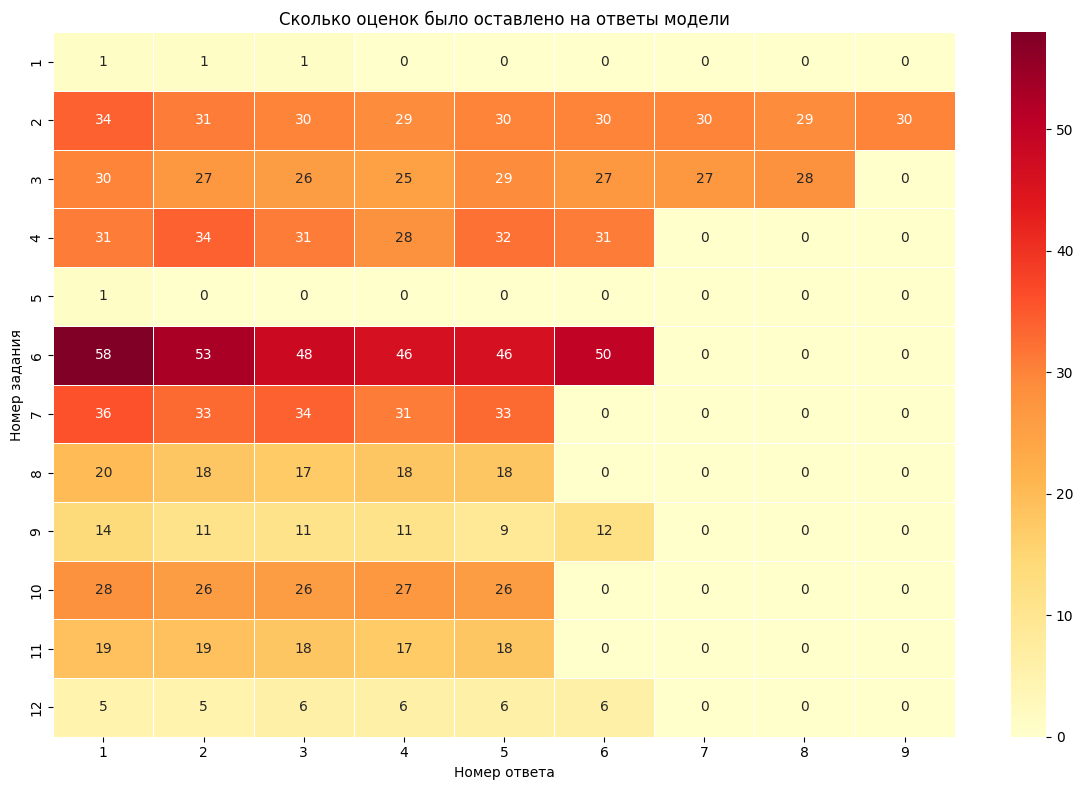

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


scoring_distribution_df = raw_feedback_df.copy()

prompt_mapping = {pid: i+1 for i, pid in enumerate(sorted(scoring_distribution_df['prompt_id'].unique()))}
scoring_distribution_df['prompt_number'] = scoring_distribution_df['prompt_id'].map(prompt_mapping)

scoring_distribution_df = scoring_distribution_df.sort_values(['prompt_id', 'response_id'])

scoring_distribution_df['response_number'] = scoring_distribution_df.groupby('prompt_id')['response_id'].rank(method='dense').astype(int)

heatmap_data = scoring_distribution_df.groupby(['prompt_number', 'response_number']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', linewidths=.5)
plt.title('Сколько оценок было оставлено на ответы модели')
plt.xlabel('Номер ответа')
plt.ylabel('Номер задания')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

def plot_distributions(df):
  # Set up subplots
  fig, axes = plt.subplots(2, 2, figsize=(14, 10))
  metrics = ['helpful', 'does_not_reveal_answer', 'does_not_contain_errors', 'only_relevant_info']
  titles = [
      'Distribution of "Helpful" Ratings',
      'Distribution of "Does Not Reveal Answer" Ratings',
      'Distribution of "Does Not Contain Errors" Ratings',
      'Distribution of "Only Relevant Info" Ratings'
  ]

  # Plot distributions
  for i, ax in enumerate(axes.flatten()):
      # Create the count plot
      sns.countplot(data=df, x=metrics[i], ax=ax, palette='viridis')
      ax.set_title(titles[i], fontsize=12)
      ax.set_xlabel('Rating Score')
      ax.set_ylabel('Count')

      # Calculate total counts for percentage calculation
      total = len(df)

      # Annotate bars with percentages
      for p in ax.patches:
          count = p.get_height()
          percentage = (count / total) * 100
          ax.annotate(f'{percentage:.1f}%',
                      (p.get_x() + p.get_width() / 2., count),
                      ha='center', va='bottom')

  plt.tight_layout()
  plt.show()

def plot_group_comparisons(df):
    """Compare metrics across user groups and models"""
    # Compare across user groups
    fig, ax = plt.subplots(2, 2, figsize=(18, 12))
    metrics = ['helpful', 'does_not_reveal_answer', 'only_relevant_info']

    for i, metric in enumerate(metrics):
        sns.boxplot(data=df, x='user_group_cd', y=metric, ax=ax[i//2, i%2], palette="Set2")
        ax[i//2, i%2].set_title(f'{metric.capitalize()} by User Group', weight='bold')

    # Model comparison heatmap
    model_scores = df.groupby('base_model_name')[metrics].mean()
    sns.heatmap(model_scores, annot=True, cmap="YlGnBu", ax=ax[1, 1])
    ax[1, 1].set_title('Average Scores by Base Model', weight='bold')

    plt.tight_layout()
    plt.show()

def plot_correlations(df):
    """Plot correlation matrix between metrics"""
    # Convert boolean to numerical for correlation
    temp_df = df.copy()
    temp_df['does_not_contain_errors'] = temp_df['does_not_contain_errors'].astype(int)

    plt.figure(figsize=(10, 8))
    corr = temp_df[['helpful', 'does_not_reveal_answer',
                   'only_relevant_info', 'does_not_contain_errors']].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title('Metric Correlation Matrix', weight='bold')
    plt.show()

def plot_model_version_analysis(df):
    """Analyze performance across model versions"""
    plt.figure(figsize=(14, 8))

    # Plot version comparison for helpfulness
    sns.violinplot(data=df, x='model_version', y='helpful',
                  hue='base_model_name', split=True, palette="Set2")
    plt.title('Helpfulness Distribution by Model Version', weight='bold')
    plt.xlabel('Model Version')
    plt.ylabel('Helpfulness Score')
    plt.legend(title='Base Model')
    plt.show()

<Figure size 1200x800 with 0 Axes>

<ipython-input-7-9d4b2f1bf5bf>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=metrics[i], ax=ax, palette='viridis')
<ipython-input-7-9d4b2f1bf5bf>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=metrics[i], ax=ax, palette='viridis')
<ipython-input-7-9d4b2f1bf5bf>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=metrics[i], ax=ax, palette='viridis')
<ipython-input-7-9d4b2f1bf5bf>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the 

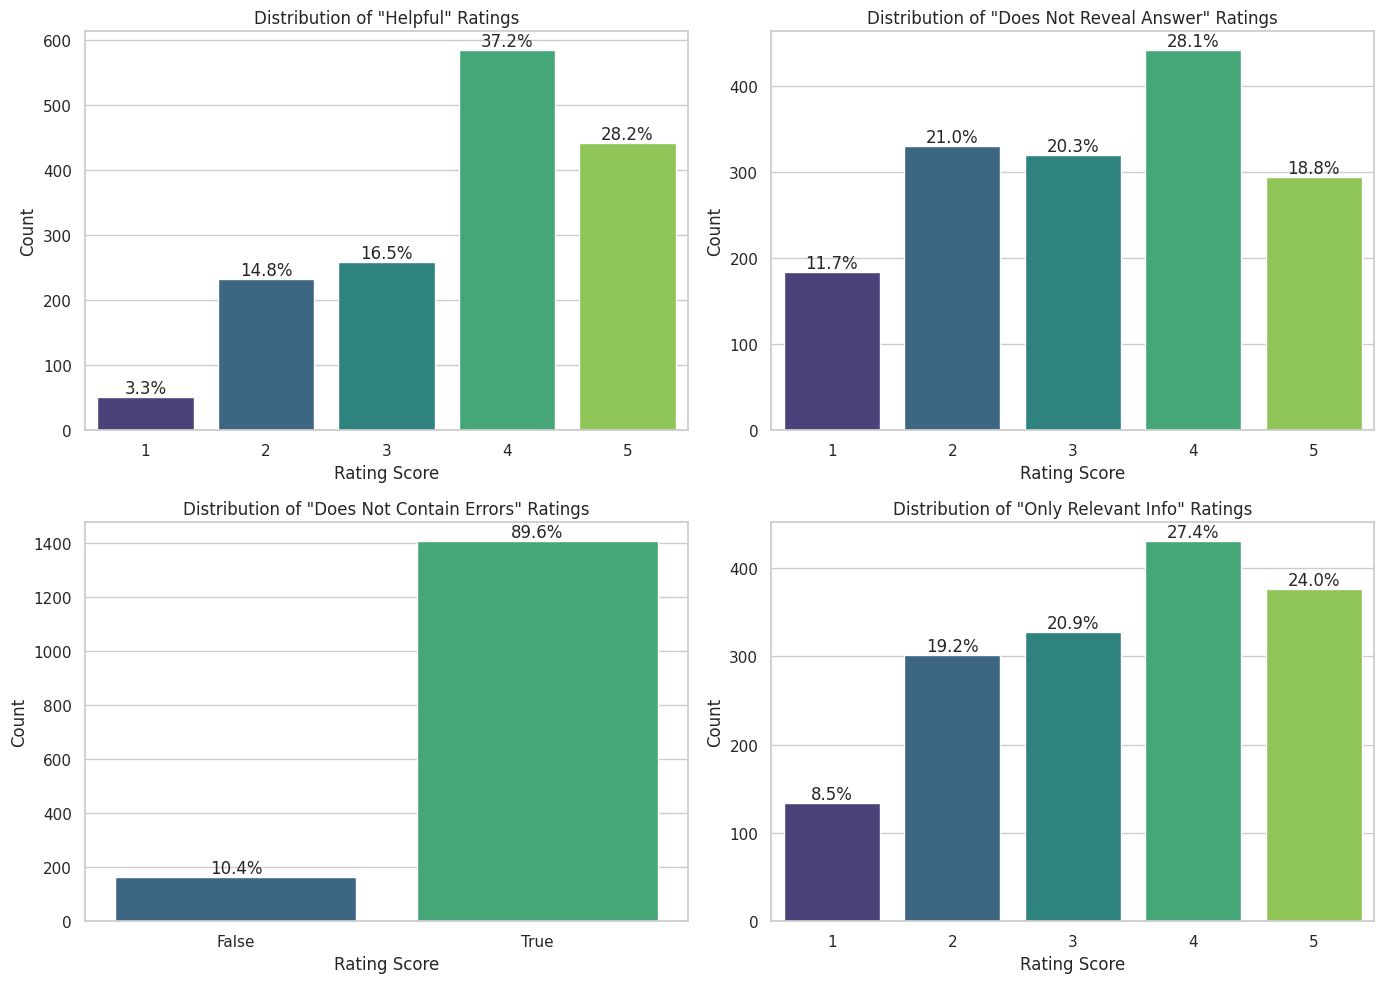

In [ ]:
plot_distributions(raw_feedback_df)

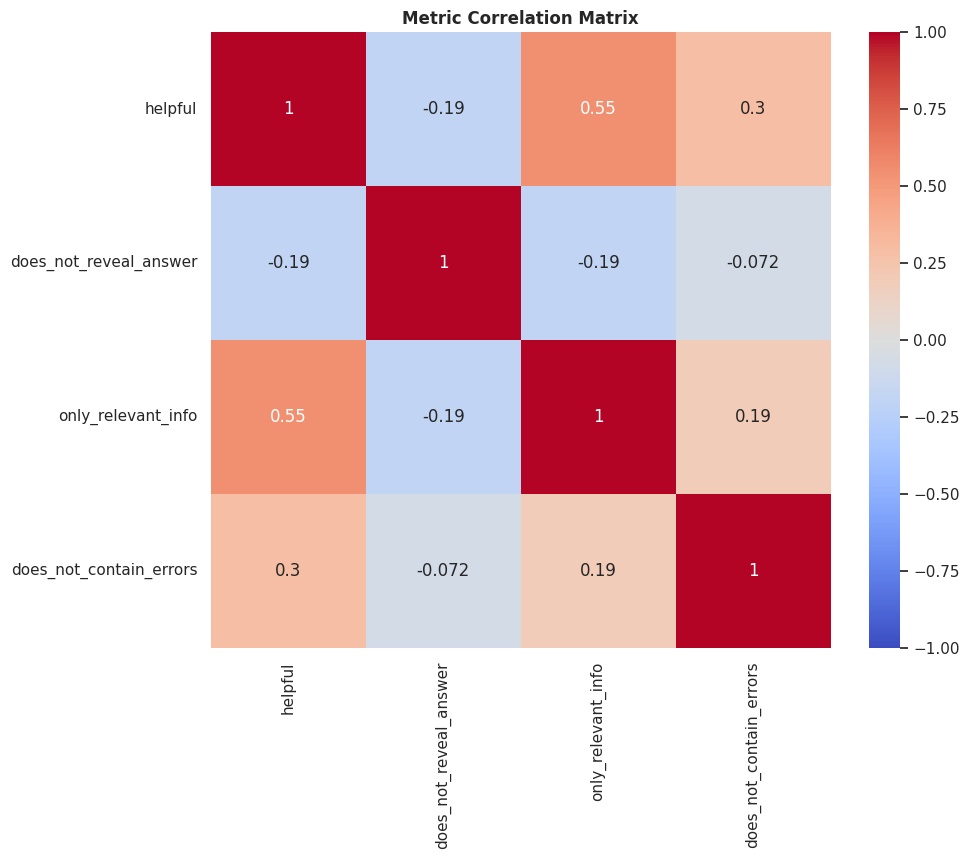

In [ ]:
plot_correlations(raw_feedback_df)

In [ ]:
def calculate_agg_score(row):
    score = (
        0.4 * row["helpful"] +          # Prioritize helpfulness
        0.3 * row["only_relevant_info"] +        # Conciseness
        0.2 * row["does_not_reveal_answer"] +
        0.5 * row["does_not_contain_errors"]    # Penalize errors heavily
    )
    return score

In [ ]:
raw_feedback_df['agg_score'] = raw_feedback_df.apply(calculate_agg_score, axis=1)

## Train - Validation - Test split

In [ ]:
from sklearn.model_selection import train_test_split


# Split the dataset into train+val (80%) and test (20%)
raw_feedback_df_train_val, raw_feedback_df_test = train_test_split(raw_feedback_df, test_size=0.2, random_state=RANDOM_STATE)

## Multimodal reward model (ArmoRM)

### Create Dataset and Embeddings

In [ ]:
import pandas as pd
import json


def form_mutimodal_df(df: pd.DataFrame) -> pd.DataFrame:
  output_df = df[['base_model_name', 'messages', 'response', 'helpful', 'does_not_reveal_answer', 'does_not_contain_errors', 'only_relevant_info']].copy()
  output_df.rename(columns={'base_model_name': 'response_model'}, inplace=True)
  output_df['dataset'] = output_df['prompt_source'] = 'hse-prog-task-transformer'
  output_df["messages"] = output_df["messages"].apply(json.loads)
  output_df["messages"] = output_df.apply(
      lambda row: row["messages"] + [{"role": "assistant", "content": row["response"]}],
      axis=1
  )
  output_df.drop(columns=['response'], inplace=True)
  dtypes = {'helpful': 'uint8', 'does_not_reveal_answer': 'uint8', 'only_relevant_info': 'uint8'}
  output_df = output_df.astype(dtypes)
  output_df['messages'].iloc[0]
  return output_df


In [ ]:
multimodal_train_val = form_mutimodal_df(raw_feedback_df_train_val)
multimodal_test = form_mutimodal_df(raw_feedback_df_test)

multimodal_train_val.head()

,response_model,messages,helpful,does_not_reveal_answer,does_not_contain_errors,only_relevant_info,dataset,prompt_source
1085,deepseek-ai/DeepSeek-V3,"[{'role': 'system', 'content': 'Ты опытный пре...",5,2,True,5,hse-prog-task-transformer,hse-prog-task-transformer
208,deepseek-ai/DeepSeek-R1,"[{'role': 'system', 'content': 'Ты опытный пре...",3,3,True,2,hse-prog-task-transformer,hse-prog-task-transformer
1053,deepseek-ai/DeepSeek-V3,"[{'role': 'system', 'content': 'Ты опытный пре...",3,4,True,2,hse-prog-task-transformer,hse-prog-task-transformer
451,deepseek-ai/DeepSeek-V3,"[{'role': 'system', 'content': 'Ты опытный пре...",1,1,False,1,hse-prog-task-transformer,hse-prog-task-transformer
415,deepseek-ai/DeepSeek-V3,"[{'role': 'system', 'content': 'Ты опытный пре...",4,4,True,4,hse-prog-task-transformer,hse-prog-task-transformer


In [ ]:
from datasets import Dataset, DatasetDict


dataset_train_val = Dataset.from_pandas(multimodal_train_val)
dataset_test = Dataset.from_pandas(multimodal_test)

#  Create DatasetDict with standard splits
dataset = DatasetDict({
    "train": dataset_train_val,
    "test": dataset_test
})

# Save as Parquet files
dataset.save_to_disk(MULTIMODAL_DATASET_SAVEPATH)

Saving the dataset (0/1 shards):   0%|          | 0/1254 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/314 [00:00<?, ? examples/s]

In [ ]:
import os
import fnmatch


# These files mess up dataset structure recognition
def delete_state_json_files(dir_path, state_filename: str = 'state.json'):
    for root, dirs, files in os.walk(dir_path):
        for filename in fnmatch.filter(files, state_filename):
            file_path = os.path.join(root, filename)
            os.remove(file_path)
            print(f'Deleted: {file_path}')


In [ ]:
delete_state_json_files(MULTIMODAL_DATASET_SAVEPATH)

Deleted: /content/multimodal_feedback/test/state.json
Deleted: /content/multimodal_feedback/train/state.json


In [ ]:
# Upload to Hugging Face Hub
from huggingface_hub import HfApi
from google.colab import userdata


api = HfApi(token=userdata.get("HF_TOKEN"))

# Upload dataset
api.upload_folder(
    folder_path=MULTIMODAL_DATASET_SAVEPATH,
    repo_id=HF_DATASET_REPO,
    repo_type="dataset",
)

data-00000-of-00001.arrow:   0%|          | 0.00/2.62M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

data-00000-of-00001.arrow:   0%|          | 0.00/10.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/il-pugin/hse-prog-task-transformer-feedback/commit/b30b3168c5e33655f12598f75b454d78a31bea33', commit_message='Upload folder using huggingface_hub', commit_description='', oid='b30b3168c5e33655f12598f75b454d78a31bea33', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/il-pugin/hse-prog-task-transformer-feedback', endpoint='https://huggingface.co', repo_type='dataset', repo_id='il-pugin/hse-prog-task-transformer-feedback'), pr_revision=None, pr_num=None)

In [ ]:
!pip3 install -q datasets flash-attn transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 111.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.0 MB/s eta 0:00:00


In [ ]:
!pip3 install -q torch torchvision torchaudio

In [ ]:
!pip install -q -U datasets huggingface_hub fsspec
# Fixes dataset load error -> restart kernel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.4/509.4 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 120.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [ ]:
import os
import torch
import datasets
import numpy as np
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
from safetensors.torch import save_file
import pandas as pd

In [ ]:
# Set up CUDA optimizations for faster computation
torch.backends.cuda.matmul.allow_tf32 = (
    True  # Enable TensorFloat-32 matrix multiplication on CUDA
)
torch.backends.cudnn.allow_tf32 = (
    True  # Allow TensorFloat-32 in cuDNN for faster convolution operations
)

# Define attributes (reward objectives)
attributes = [
    'helpful',
    'does_not_reveal_answer',
    'does_not_contain_errors',
    'only_relevant_info',
]


MODEL_PATH = "sfairXC/FsfairX-LLaMA3-RM-v0.1"
DATASET_PATH = HF_DATASET_REPO
N_SHARDS = 1
SHARD_IDX = 1
DEVICE = 0

In [ ]:
# Load the specified dataset and prepare it for processing
ds_train_val = datasets.load_dataset(DATASET_PATH, split="train") # Load the training split of the dataset
ds_train_val = ds_train_val.shuffle(seed=RANDOM_STATE)  # Shuffle the dataset to ensure randomness

ds_test = datasets.load_dataset(DATASET_PATH, split="test")

data-00000-of-00001.arrow:   0%|          | 0.00/10.4M [00:00<?, ?B/s]

data-00000-of-00001.arrow:   0%|          | 0.00/2.62M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1254 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/314 [00:00<?, ? examples/s]

In [ ]:
# Scale the labels to 0-1 interval to simplify fitting the model
class CustomScaler():
  def __init__(self, source_range: tuple, feature_range: tuple = (0, 1)) -> None:
    self.source_range = source_range
    self.feature_range = feature_range
    self.scale_ = (self.feature_range[1] - self.feature_range[0]) / (self.source_range[1] - self.source_range[0])
    self.min_ = self.source_range[0]

  def transform(self, X):
    return (X - self.min_) * self.scale_


In [ ]:
# For some reason datasets.Dataset.map fails to cast 'does_not_contain_errors' -> use pandas.DataFrame operations

df_train_val = ds_train_val.to_pandas()
df_test = ds_test.to_pandas()

In [ ]:
def transform(df: pd.DataFrame) -> None:
  df['does_not_contain_errors'] = df['does_not_contain_errors'].astype('float')
  # Scale the labels
  scaler = CustomScaler(source_range=(1, 5), feature_range=(0, 1))
  for label in ['helpful', 'does_not_reveal_answer', 'only_relevant_info']:
      df[label] = scaler.transform(df[label].astype(float))


In [ ]:
transform(df_train_val)
transform(df_test)

In [ ]:
from datasets import Dataset

ds_train_val = Dataset.from_pandas(df_train_val)
ds_test = Dataset.from_pandas(df_test)

In [ ]:
if N_SHARDS > 1:
    ds_train_val = ds_train_val.shard(
        num_shards=N_SHARDS, index=SHARD_IDX - 1
    )  # Divide dataset into shards if needed
    ds_test = ds_test.shard(
        num_shards=N_SHARDS, index=SHARD_IDX - 1
    )

In [ ]:
# Load the pre-trained model and tokenizer from the specified path
rm = AutoModel.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.bfloat16,  # Use bfloat16 precision for model weights to save memory
    attn_implementation="flash_attention_2",  # Specify the attention implementation for efficiency
)

device = f"cuda:{DEVICE}"  # Define the CUDA device string
rm = rm.to(device)  # Move the model to the specified CUDA device
rm_tokenizer = AutoTokenizer.from_pretrained(
    MODEL_PATH
)  # Load the tokenizer associated with the model


config.json:   0%|          | 0.00/849 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/51.2k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

In [ ]:
def create_embeddings(ds: datasets.Dataset, subdir_path: str = "") -> None:
  # Initialize lists to store embeddings and corresponding labels
  embeddings = []
  labels = []

  # Iterate over each example in the dataset with a progress bar
  for example in tqdm(ds, desc="Processing dataset"):
      # Format the conversation messages using the tokenizer's chat template without tokenization
      if MODEL_PATH.endswith("FsfairX-LLaMA3-RM-v0.1"):
          # Follows the demo code: https://huggingface.co/sfairXC/FsfairX-LLaMA3-RM-v0.1
          conv_formatted = rm_tokenizer.apply_chat_template(
              example["messages"], tokenize=False, add_generation_prompt=False
          ).replace(rm_tokenizer.bos_token, "")
      else:
          conv_formatted = rm_tokenizer.apply_chat_template(
              example["messages"], tokenize=False
          )
      # Tokenize the formatted conversation and move tensors to the specified device
      conv_tokenized = rm_tokenizer(conv_formatted, return_tensors="pt").to(device)

      with torch.no_grad():
          output = rm(**conv_tokenized)  # Forward pass through the model
          # Extract the last hidden state of the last token and move it to CPU
          embeddings.append(output.last_hidden_state[0][-1].cpu())

      # Extract labels for the current example based on predefined attributes
      label = [example[attr] for attr in attributes]
      # Replace None values with NaN for consistent numerical processing
      label = [np.nan if l is None else l for l in label]
      labels.append(label)  # Append the processed labels to the list

  # Convert the list of labels to a NumPy array with float32 precision
  labels = np.array(labels, dtype=np.float32)
  labels = torch.from_numpy(labels)  # Convert the NumPy array to a PyTorch tensor
  embeddings = torch.stack(embeddings, dim=0)  # Stack all embeddings into a single tensor

  # Define the path to save the embeddings and labels
  HOME = os.path.expanduser("~")  # Get the home directory of the current user
  model_name = MODEL_PATH.split("/")[
      -1
  ]  # Extract the model name from the model path
  dataset_name = DATASET_PATH.split("/")[
      -1
  ]  # Extract the dataset name from the dataset path
  save_path = os.path.join(
      HOME, "data", "ArmoRM", "embeddings", model_name, dataset_name, subdir_path
  )  # Construct the save directory path
  os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist

  # Save the embeddings and labels in a safetensors file with shard indexing
  save_file(
      {"embeddings": embeddings, "labels": labels},
      f"{save_path}-{SHARD_IDX:05d}-of-{N_SHARDS:05d}.safetensors",
  )

  # Print a confirmation message with the path to the saved embeddings
  print(
      f"Saved embeddings to {save_path}-{SHARD_IDX:05d}-of-{N_SHARDS:05d}.safetensors"
  )

In [ ]:
create_embeddings(ds=ds_train_val, subdir_path="train")

Processing dataset:   0%|          | 0/1254 [00:00<?, ?it/s]

Saved embeddings to /root/data/ArmoRM/embeddings/FsfairX-LLaMA3-RM-v0.1/hse-prog-task-transformer-feedback/train-00001-of-00001.safetensors


In [ ]:
create_embeddings(ds=ds_test, subdir_path="test")

Processing dataset:   0%|          | 0/314 [00:00<?, ?it/s]

Saved embeddings to /root/data/ArmoRM/embeddings/FsfairX-LLaMA3-RM-v0.1/hse-prog-task-transformer-feedback/test-00001-of-00001.safetensors


### Train Regression model

In [ ]:
import os
import torch
import numpy as np
from typing import List, Tuple
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from safetensors.torch import load_file

In [ ]:
def prepare_embeddings_and_labels(embeddings_path: str) -> Tuple[np.ndarray, np.ndarray]:
  # Collect all embedding files matching the pattern embeddings_path-*.safetensors
  embedding_files = sorted(glob(f"{embeddings_path}-*.safetensors"))

  embeddings = []
  labels = []
  print("Loading embeddings and labels from Safetensors files...")
  for file in tqdm(embedding_files, desc="Loading embeddings"):
      # Load the safetensors file
      data = load_file(file)
      embeddings.append(data["embeddings"])  # Append embeddings tensor
      labels.append(data["labels"])  # Append labels tensor

  # Concatenate all embeddings and labels into single tensors
  embeddings = torch.cat(embeddings, dim=0).float().numpy()
  labels = torch.cat(labels, dim=0).float().numpy()

  print(f"Total embeddings loaded: {embeddings.shape[0]}")
  print(f"Total labels loaded: {labels.shape[0]}")
  return embeddings, labels

In [ ]:
"""
Perform multi-objective linear regression on precomputed embeddings.
This script loads embeddings and labels, splits the data into training and validation sets,
trains Ridge regression models for each attribute across a range of regularization strengths (alphas),
selects the best alpha based on validation loss, and saves the resulting regression weights.
"""

# ---------------------------
# Argument Parsing
# ---------------------------
MODEL_PATH = "sfairXC/FsfairX-LLaMA3-RM-v0.1"
DATASET_PATH = "il-pugin/hse-prog-task-transformer-feedback"
EMBEDDINGS_DIR = "/root/data/ArmoRM/embeddings/FsfairX-LLaMA3-RM-v0.1/hse-prog-task-transformer-feedback/train"
OUTPUT_DIR = "/root/data/ArmoRM/regression_weights/"

# Extract names from paths
model_name = MODEL_PATH.split("/")[-1]
dataset_name = DATASET_PATH.split("/")[-1]

# ---------------------------
# Configuration and Setup
# ---------------------------
# Define the reward attributes as per the method overview in README.md
attributes = [
    'helpful',
    'does_not_reveal_answer',
    'does_not_contain_errors',
    'only_relevant_info',
]

# Set the home directory
HOME = os.path.expanduser("~")

# Define the path to the embeddings based on user input or default location
if EMBEDDINGS_DIR:
    embeddings_path = EMBEDDINGS_DIR
else:
    embeddings_path = os.path.join(
        HOME, "data", "ArmoRM", "embeddings", model_name, dataset_name
    )

# ---------------------------
# Loading Embeddings and Labels
# ---------------------------
embeddings, labels = prepare_embeddings_and_labels(embeddings_path=embeddings_path)

Loading embeddings and labels from Safetensors files...


Loading embeddings: 100%|██████████| 1/1 [00:00<00:00, 638.21it/s]

Total embeddings loaded: 1254
Total labels loaded: 1254


In [ ]:
# ---------------------------
# Defining Regularization Strengths (Alphas)
# ---------------------------
# Define a range of alpha values for Ridge regression
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
print(f"Using alphas: {alphas}")

# Initialize a DataFrame to store the results of each Ridge regression
df = pd.DataFrame(columns=["attribute", "alpha", "loss", "train_loss"])

# ---------------------------
# Ridge Regression Training with 5-Fold CV
# ---------------------------
print("Training Ridge regression models with 5-fold CV for each attribute and alpha...")
for attr_idx in tqdm(range(labels.shape[1]), desc="Attributes"):
  # Get labels for current attribute and filter NaNs
  y_all = labels[:, attr_idx]
  valid_mask = ~np.isnan(y_all)
  X_filtered = embeddings[valid_mask]
  y_filtered = y_all[valid_mask]

  # Skip if insufficient samples for CV
  if len(y_filtered) < 5:
      print(f"Skipping attribute {attr_idx} - insufficient samples after filtering.")
      continue

  # Set up 5-fold cross-validator
  kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

  for alpha in tqdm(alphas, desc=f"Alpha for attribute {attr_idx}", leave=False):
      fold_losses = []
      fold_train_losses = []

      # Perform cross-validation
      for train_idx, val_idx in kf.split(X_filtered):
        # Split data for this fold
        X_train_fold, X_val_fold = X_filtered[train_idx], X_filtered[val_idx]
        y_train_fold, y_val_fold = y_filtered[train_idx], y_filtered[val_idx]

        # Train and evaluate model
        clf = Ridge(alpha=alpha, fit_intercept=False)
        clf.fit(X_train_fold, y_train_fold)

        train_pred = clf.predict(X_train_fold)
        pred = clf.predict(X_val_fold)

        fold_train_loss = mean_squared_error(y_train_fold, train_pred)
        fold_loss = mean_squared_error(y_val_fold, pred)

        fold_train_losses.append(fold_train_loss)
        fold_losses.append(fold_loss)

      # Calculate average loss across folds
      avg_loss = np.mean(fold_losses)
      avg_train_loss = np.mean(fold_train_losses)
      df = df._append(
          {"attribute": attr_idx, "alpha": alpha, "loss": avg_loss, "train_loss": avg_train_loss},
          ignore_index=True
      )

# ---------------------------
# Selecting Best Alphas Based on Cross-Validation Loss
# ---------------------------
print("Selecting the best alpha for each attribute based on cross-validation loss...")
best_alphas = df.loc[df.groupby("attribute")["loss"].idxmin()]
print("Best alphas selected for each attribute:")
print(best_alphas)

Loading embeddings and labels from Safetensors files...


Loading embeddings: 100%|██████████| 1/1 [00:00<00:00, 502.73it/s]


Total embeddings loaded: 1254
Total labels loaded: 1254
Using alphas: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
Training Ridge regression models with 5-fold CV for each attribute and alpha...


Alpha for attribute 0:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
<ipython-input-

Selecting the best alpha for each attribute based on cross-validation loss...
Best alphas selected for each attribute:
    attribute   alpha      loss  train_loss
7         0.0  1000.0  0.074957    0.072632
16        1.0  1000.0  0.102339    0.099803
24        2.0   100.0  0.089329    0.082223
34        3.0  1000.0  0.097176    0.094211


### Plot training progress

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve


def plot_alpha_error_paths(df):
    """Plot validation error vs alpha values for all attributes on shared axes"""
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Get unique attributes and assign colors
    attributes = df['attribute'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(attributes)))

    for attr_idx, color in zip(attributes, colors):
        attr_data = df[df['attribute'] == attr_idx]
        ax.plot(attr_data['alpha'], attr_data['loss'], 'o-',
                color=color, label=f'Attr {attr_idx}')

        # Add train loss as transparent line
        ax.plot(attr_data['alpha'], attr_data['train_loss'], '--',
                color=color, alpha=0.3)

    ax.set_xscale('log')
    ax.set_title('All Attributes - CV Error vs Regularization Strength')
    ax.set_xlabel('Alpha (log scale)')
    ax.set_ylabel('Mean Squared Error')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_coefficient_paths(df, embeddings, labels, alphas):
    """Plot coefficient paths for all attributes on shared heatmap"""
    plt.figure(figsize=(14, 10))

    attributes = sorted(df['attribute'].unique())
    n_plots = len(attributes)
    n_cols = 3
    n_rows = int(np.ceil(n_plots / n_cols))

    for i, attr_idx in enumerate(range(labels.shape[1]), 1):
        plt.subplot(n_rows, n_cols, i)

        # Filter data for current attribute
        y = labels[:, attr_idx]
        valid_mask = ~np.isnan(y)
        X = embeddings[valid_mask]
        y = y[valid_mask]

        # Calculate coefficients
        coefs = []
        for alpha in alphas:
            ridge = Ridge(alpha=alpha, fit_intercept=False)
            ridge.fit(X, y)
            coefs.append(ridge.coef_)

        # Plot heatmap of coefficients
        sns.heatmap(np.array(coefs).T,
                   xticklabels=[f"{a:.1f}" for a in alphas],
                   yticklabels=False,
                   cmap='coolwarm',
                   center=0)
        plt.title(f'Attr {attributes[attr_idx]} Coefficients')
        plt.xlabel('Alpha (log scale)')

    plt.suptitle('Coefficient Paths Across Attributes', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_learning_curves(df, embeddings, labels, attribute_names, metric_nm):
    """Plot learning curves for best alpha of each attribute"""
    plt.figure(figsize=(14, 10))

    attributes = sorted(df['attribute'].unique())
    n_plots = len(attributes)
    n_cols = 3
    n_rows = int(np.ceil(n_plots / n_cols))

    for i, attr_idx in enumerate(range(labels.shape[1]), 1):
        plt.subplot(n_rows, n_cols, i)

        # Get best alpha
        attr_data = df[df['attribute'] == attr_idx]
        best_alpha = attr_data.loc[attr_data['loss'].idxmin(), 'alpha']

        # Prepare data
        y = labels[:, attr_idx]
        valid_mask = ~np.isnan(y)
        X = embeddings[valid_mask]
        y = y[valid_mask]

        # Calculate learning curves
        train_sizes, train_scores, test_scores = learning_curve(
            Ridge(alpha=best_alpha, fit_intercept=False),
            X, y, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='neg_mean_squared_error'
        )

        train_scores_mean = -np.mean(train_scores, axis=1)
        test_scores_mean = -np.mean(test_scores, axis=1)

        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Train")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="CV")
        plt.title(f'Attr {attribute_names[attr_idx]} (α={best_alpha:.2e})')
        plt.xlabel("Iterations")
        plt.ylabel(metric_nm)
        plt.grid(True)

        if i == 1:  # Only show legend for first subplot
            plt.legend()

    plt.suptitle('Learning Curves for Best Alpha per Attribute', y=1.02)
    plt.tight_layout()
    plt.show()

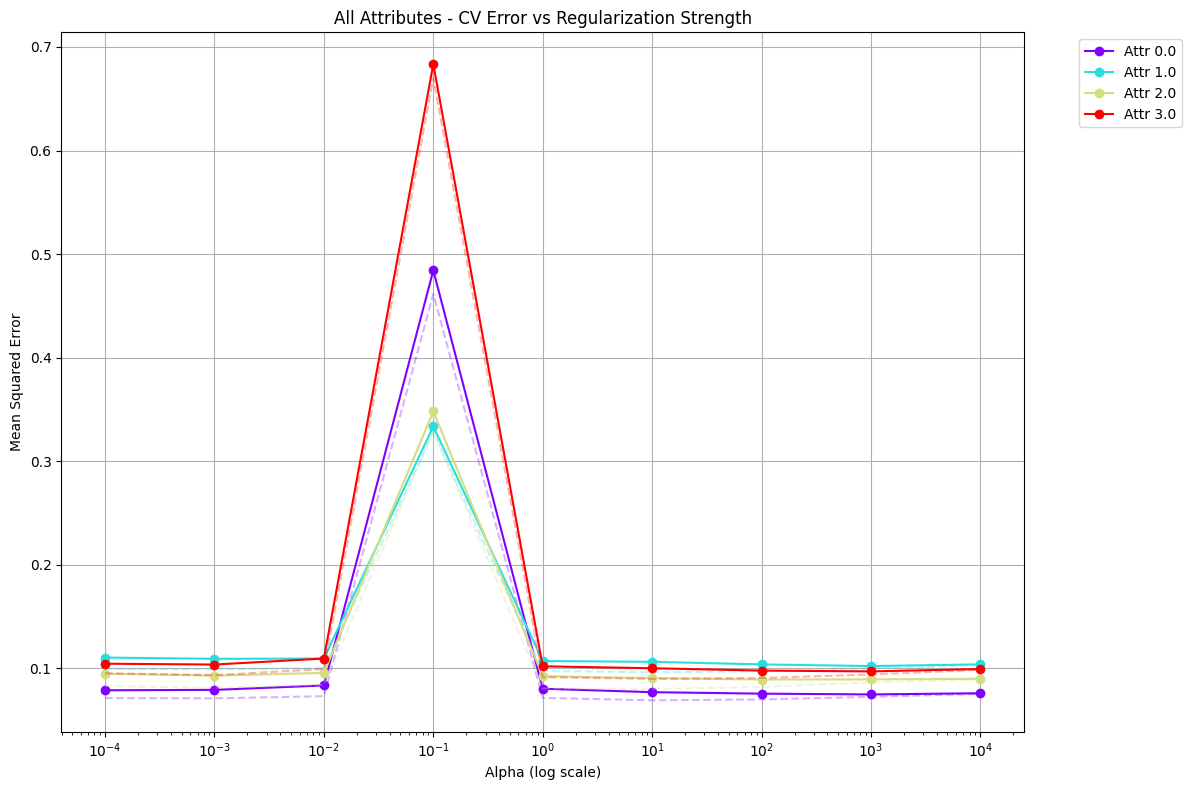

In [ ]:
plot_alpha_error_paths(df=df)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=2.77333e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=1.06224e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", ov

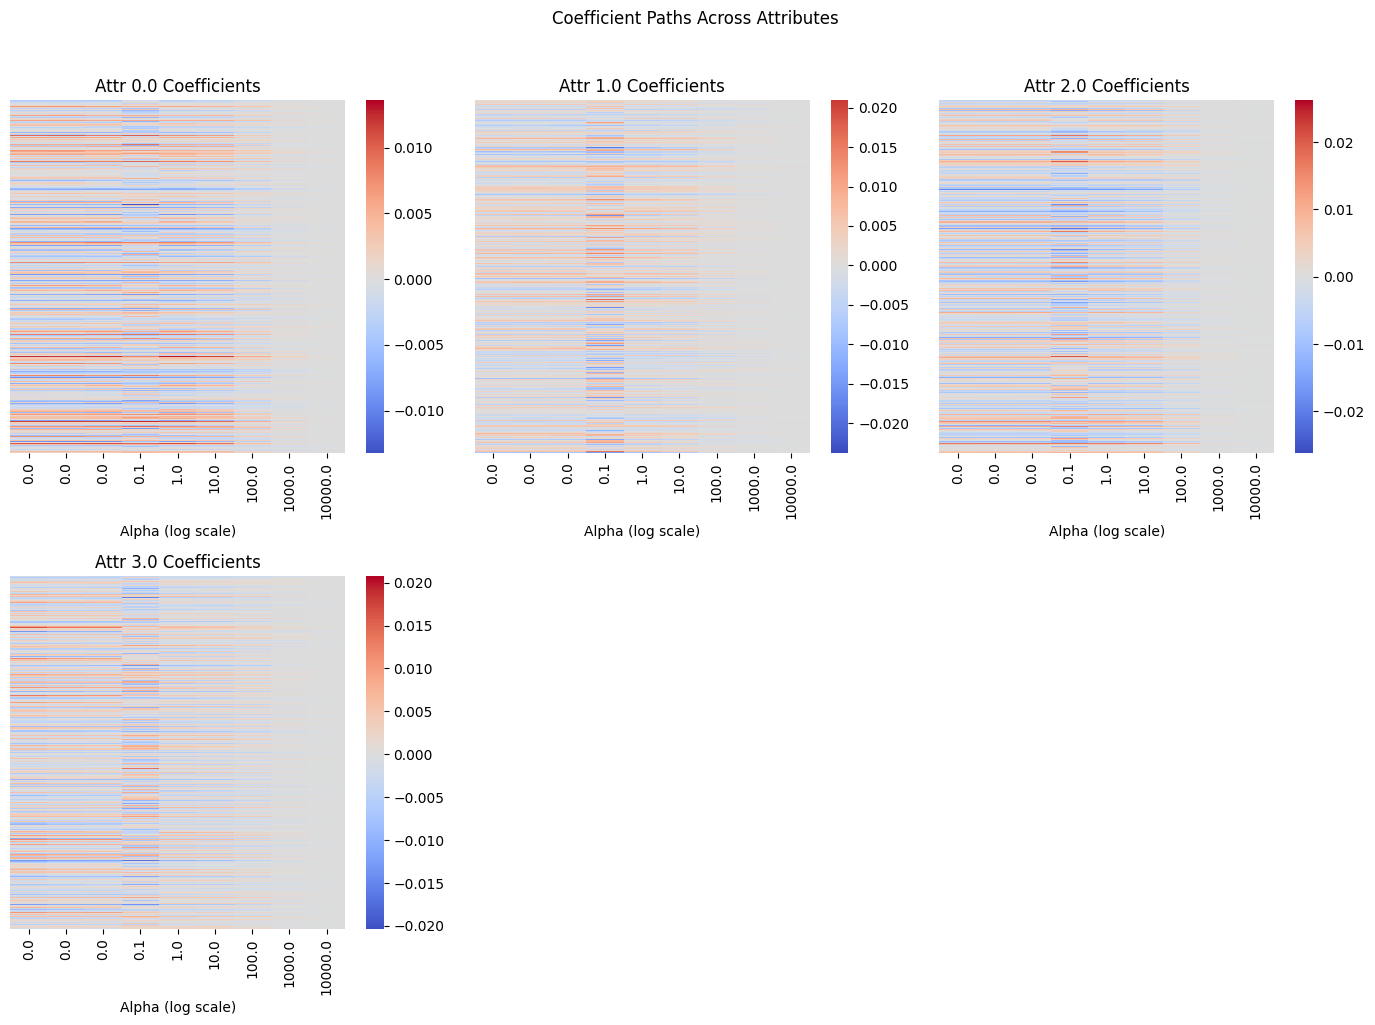

In [ ]:
plot_coefficient_paths(df=df, embeddings=embeddings, labels=labels, alphas=alphas)

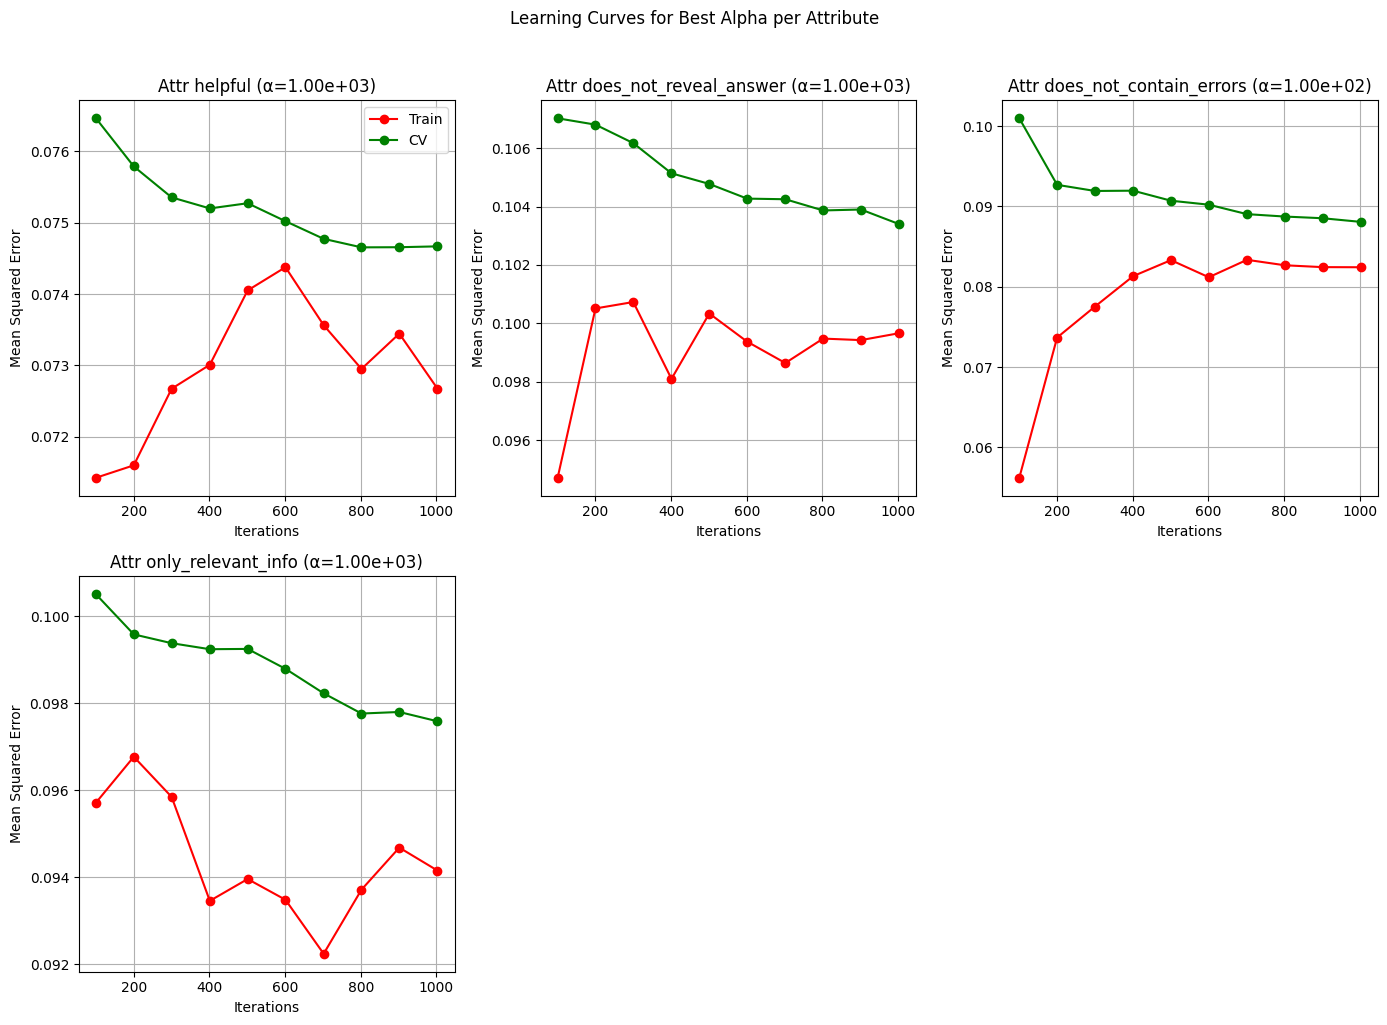

In [ ]:
plot_learning_curves(df=df, embeddings=embeddings, labels=labels, attribute_names=attributes, metric_nm = "Mean Squared Error")

### Evaluate performance on Test set

In [ ]:
# ---------------------------
# Configuration and Setup
# ---------------------------
# Define the reward attributes as per the method overview in README.md
attributes = [
    'helpful',
    'does_not_reveal_answer',
    'does_not_contain_errors',
    'only_relevant_info',
]

TEST_EMBEDDINGS_DIR = "/root/data/ArmoRM/embeddings/FsfairX-LLaMA3-RM-v0.1/hse-prog-task-transformer-feedback/test"

# Set the home directory
HOME = os.path.expanduser("~")

# Define the path to the embeddings based on user input or default location
if TEST_EMBEDDINGS_DIR:
    embeddings_path = TEST_EMBEDDINGS_DIR
else:
    embeddings_path = os.path.join(
        HOME, "data", "ArmoRM", "embeddings", model_name, dataset_name
    )

# ---------------------------
# Loading Embeddings and Labels
# ---------------------------
test_embeddings, test_labels = prepare_embeddings_and_labels(embeddings_path=embeddings_path)

Loading embeddings and labels from Safetensors files...


Loading embeddings: 100%|██████████| 1/1 [00:00<00:00, 1160.89it/s]

Total embeddings loaded: 314
Total labels loaded: 314


In [ ]:
test_losses = []

for index, row in tqdm(
    best_alphas.iterrows(), total=best_alphas.shape[0], desc="Final Models"
):
    attr_idx = int(row["attribute"])
    best_alpha = row["alpha"]

    # Initialize Ridge model with the best alpha
    clf = Ridge(alpha=best_alpha, fit_intercept=False)

    # Prepare training data
    y_train = labels[:, attr_idx]
    valid_mask_train = ~np.isnan(y_train)
    X_train_filtered = embeddings[valid_mask_train]
    y_train_filtered = y_train[valid_mask_train]

    # Train the model
    clf.fit(X_train_filtered, y_train_filtered)

    # Calculate loss on test set for reporting
    y_val = test_labels[:, attr_idx]
    valid_mask_val = ~np.isnan(y_val)
    X_val_filtered = test_embeddings[valid_mask_val]
    y_val_filtered = y_val[valid_mask_val]
    pred = clf.predict(X_val_filtered)
    loss = mean_squared_error(y_val_filtered, pred)

    test_losses.append(loss)

best_alphas['test_loss'] = test_losses
best_alphas['attr_name'] = attributes

print("Updated stats with Test set losses")
best_alphas

Final Models: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

Updated stats with Test set losses


,attribute,alpha,loss,train_loss,test_loss,attr_name
7,0.0,1000.0,0.074957,0.072632,0.077110,helpful
16,1.0,1000.0,0.102339,0.099803,0.096903,does_not_reveal_answer
24,2.0,100.0,0.089329,0.082223,0.099261,does_not_contain_errors
34,3.0,1000.0,0.097176,0.094211,0.094193,only_relevant_info


### Train models with selected hyperparameters

In [ ]:
# Use all available data for final model
total_embeddings = np.concatenate((embeddings, test_embeddings), axis=0)
total_labels = np.concatenate((labels, test_labels), axis=0)

In [ ]:
# ---------------------------
# Fitting Final Models with Best Alphas and Extracting Weights
# ---------------------------
print(
    "Fitting final Ridge regression models with the best alphas and extracting weights..."
)
weights = []

for index, row in tqdm(
    best_alphas.iterrows(), total=best_alphas.shape[0], desc="Final Models"
):
    attr_idx = int(row["attribute"])
    best_alpha = row["alpha"]

    # Initialize Ridge model with the best alpha
    clf = Ridge(alpha=best_alpha, fit_intercept=False)

    # Prepare training data
    y_train = total_labels[:, attr_idx]
    valid_mask_train = ~np.isnan(y_train)
    X_train_filtered = total_embeddings[valid_mask_train]
    y_train_filtered = y_train[valid_mask_train]

    # Train the model
    clf.fit(X_train_filtered, y_train_filtered)

    # Append the coefficient (weight) for the current attribute
    weights.append(clf.coef_)


# Stack all weights into a single NumPy array
weights = np.stack(weights)
print(f"All regression weights shape: {weights.shape}")

# ---------------------------
# Saving the Regression Weights
# ---------------------------
# Define the output directory
if OUTPUT_DIR:
    save_dir = OUTPUT_DIR
else:
    save_dir = os.path.join(HOME, "data", "ArmoRM", "regression_weights")

os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Define the path to save the weights
save_path = os.path.join(save_dir, f"{model_name}_{dataset_name}.pt")

# Save the weights as a PyTorch tensor
torch.save({"weight": torch.from_numpy(weights)}, save_path)
print(f"Saved regression weights to {save_path}")

Fitting final Ridge regression models with the best alphas and extracting weights...


Final Models: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]

All regression weights shape: (4, 4096)
Saved regression weights to /root/data/ArmoRM/regression_weights/FsfairX-LLaMA3-RM-v0.1_hse-prog-task-transformer-feedback.pt


In [ ]:
from transformers import PretrainedConfig, AutoConfig, AutoModel, PreTrainedModel
from torch import nn

# Configuration
class RewardModelConfig(PretrainedConfig):
    model_type = "reward_model"

    def __init__(self, base_model_config=None, attributes=None, **kwargs):
        # Store the original transformer config
        self.base_model_config = base_model_config or {}
        self.attributes = attributes or []
        # Initialize with combined parameters
        super().__init__(**{**self.base_model_config, **kwargs})

# Model class
class RewardModel(PreTrainedModel):
    config_class = RewardModelConfig

    def __init__(self, config):
        super().__init__(config)

        # Recreate base model config from stored parameters
        base_config = AutoConfig.for_model(**config.base_model_config)

        # Initialize base transformer
        self.transformer = AutoModel.from_config(base_config)

        # Initialize regression heads
        self.regression_heads = nn.Linear(
            base_config.hidden_size,
            len(config.attributes),
            bias=False
        )

    def forward(self, input_ids, attention_mask=None):
        outputs = self.transformer(input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state[:, -1, :]
        return self.regression_heads(last_hidden)

# Registration (only needed when saving/loading)
AutoConfig.register(RewardModelConfig.model_type, RewardModelConfig)
AutoModel.register(RewardModelConfig, RewardModel)


In [ ]:
def save_model(save_path: str):
    # Create config with original model's config
    base_config = rm.config.to_dict()  # Your original transformer config
    config = RewardModelConfig(
        base_model_config=base_config,
        attributes=attributes
    )

    # Create model with combined config
    model = RewardModel(config)

    # Load trained weights
    model.transformer.load_state_dict(rm.state_dict())
    model.regression_heads.weight.data = torch.tensor(weights).float()

    # Save with custom files
    model.save_pretrained(
        save_path,
        safe_serialization=True
    )

In [ ]:
SAVE_PATH = "./final_reward_model"

In [ ]:
save_model(save_path=SAVE_PATH)

In [ ]:
from huggingface_hub import upload_folder

upload_folder(
    folder_path=SAVE_PATH,
    repo_id="il-pugin/hse-prog-task-transformer-reward-model",
    commit_message="Update model",
    allow_patterns=["*.json", "*.py", "*.md", "*.txt", "*.safetensors"],
)

CommitInfo(commit_url='https://huggingface.co/il-pugin/hse-prog-task-transformer-reward-model/commit/0dde554fd1c050dd78bfd225d2b7ae8f39cece94', commit_message='Update model', commit_description='', oid='0dde554fd1c050dd78bfd225d2b7ae8f39cece94', pr_url=None, repo_url=RepoUrl('https://huggingface.co/il-pugin/hse-prog-task-transformer-reward-model', endpoint='https://huggingface.co', repo_type='model', repo_id='il-pugin/hse-prog-task-transformer-reward-model'), pr_revision=None, pr_num=None)

## Scalar Reward Model